In [164]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
%matplotlib inline

Approach taken from NCSS' guide [Two Proportions – Non-Inferiority, Superiority, Equivalence, and Two-Sided Tests vs. a Margin](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Two_Proportions-Non-Inferiority,_Superiority,_Equivalence,_and_Two-Sided_Tests_vs_a_Margin.pdf), as with previous statistical approaches (i.e. as their guides include detailed formulae).

In [95]:
data = {'test': [60, 1000-60], 'ctrl': [70, 1000-70]}
# N.B. convention = test is n1 and p1, ctrl is n2 and p2, hence the order

df = pd.DataFrame.from_dict(data, orient='index',
                            columns=['don', 'non'])
print(df)

      don  non
test   60  940
ctrl   70  930


In [96]:
delta = -0.01  # The non-inferiority margin

Take the test statistic from p19-20.

In [97]:
df['total'] = df.sum(axis=1)
[n1, n2] = df['total']
N = n1 + n2
[p1, p2] = df['don'] / df['total']
print('Test: {}, {}\nCtrl: {}, {}'.format(n1, p1, n2, p2))

Test: 1000, 0.06
Ctrl: 1000, 0.07


In [98]:
l0 = df.loc['ctrl', 'don'] * delta * (1 - delta)
l1 = (n2*delta - N - 2*df.loc['ctrl', 'don']) * delta + df['don'].sum()
l2 = (N + n2)*delta - N - df['don'].sum()
l3 = N
for i in [l0, l1, l2, l3]:
    print(i)

-0.7070000000000001
151.5
-2160.0
2000


In [99]:
C = (l2**3 / (27 * (l3**3))) - (l1*l2)/(6 * (l3**2)) + l0/(2*l3)
B = np.sign(C) * np.sqrt((l2**2)/(9 * (l3**2)) - l1/(3*l3))
A = (1/3) * (np.pi + np.arccos(C/(B**3)))
print(C, B, A)

-0.033197750000000005 -0.3230325061042619 1.10529455981647


In [100]:
p2_cd = 2*B*np.cos(A) - l2/(3*l3)  # constrained p
p1_cd = p2_cd + delta
print(p1_cd, p2_cd, p1_cd - p2_cd)

0.059999999999999505 0.06999999999999951 -0.010000000000000002


In [101]:
z_MND_num = p1 - p2 - delta
z_MND_den = (p1_cd*(1-p1_cd)/n1 + p2_cd*(1-p2_cd)/n2) * N / (N-1)
z_MND_den = np.sqrt(z_MND_den)
z_MND = z_MND_num / z_MND_den
print(z_MND)

-7.86689802094413e-16


p38 => this is treated as a standard z-score, and therefore is turned into a p-value by:

In [102]:
norm.cdf(z_MND)

0.49999999999999967

It being p=0.5 for a situ where the observed difference seen is the actual NIM makes sense! Looks good => to functionify it:

In [107]:
def mndifference(datafr, nim):
    """Perform the Miettinen-Nurminen Large-Sample Score Test of the Difference.
    
    Parameters
    ----------
    datafr : pd.DataFrame
        The data to run the test on.
        Columns: don, non, total
        Index: test, ctrl
        N.B. the convention here is that the experiment is indexed as 1, and the control as 2, in reverse of normal.
    nim : float, <0 when lower is worse.
        The Non-Inferiority Margin: the amount that P1 can be less than P2 and you still conclude that
        group 1 (treatment) is not inferior to group 2 (control).

    Returns
    -------
    ? : ?
        Blah
    """
    [n1, n2] = datafr['total']
    N = n1 + n2
    [p1, p2] = datafr['don'] / datafr['total']
    
    l0 = datafr.loc['ctrl', 'don'] * nim * (1 - nim)
    l1 = (n2*nim - N - 2*datafr.loc['ctrl', 'don']) * nim + datafr['don'].sum()
    l2 = (N + n2)*nim - N - datafr['don'].sum()
    l3 = N
    
    C = (l2**3 / (27 * (l3**3))) - (l1*l2)/(6 * (l3**2)) + l0/(2*l3)
    B = np.sign(C) * np.sqrt((l2**2)/(9 * (l3**2)) - l1/(3*l3))
    A = (1/3) * (np.pi + np.arccos(C/(B**3)))
    
    p2_cd = 2*B*np.cos(A) - l2/(3*l3)  # constrained p
    p1_cd = p2_cd + nim
    
    z_MND_num = p2 - p1 + nim
    z_MND_den = (p1_cd*(1-p1_cd)/n1 + p2_cd*(1-p2_cd)/n2) * N / (N-1)
    z_MND_den = np.sqrt(z_MND_den)
    z_MND = z_MND_num / z_MND_den

    return z_MND, norm.cdf(1-z_MND)


print(mndifference(df, delta))

(7.86689802094413e-16, 0.8413447460685428)


In [108]:
diff_range = 300
differences = range(-diff_range, diff_range+1, 100)
# step_nim = -0.04

for diff in differences:
    ctrl_convs = 1200
    cell_size = 10000
    test_convs = ctrl_convs + diff
    step_nim = - (ctrl_convs / cell_size) / 3
    step_data = {'test': [test_convs, cell_size-test_convs, cell_size],
                 'ctrl': [ctrl_convs, cell_size-ctrl_convs, cell_size]}
    step_df = pd.DataFrame.from_dict(step_data, orient='index', columns=['don', 'non', 'total'])
    step_z, step_p = mndifference(step_df, step_nim)
    step_p1 = step_df.loc['test', 'don'] / step_df.loc['test', 'total']
    step_p2 = step_df.loc['ctrl', 'don'] / step_df.loc['ctrl', 'total']
    print(step_df, '\nctr1 = {}\nctr2 = {}\nz: {}\np: {}\nNIM: {}'.format(step_p1, step_p2, step_z, step_p, step_nim))

       don   non  total
test   900  9100  10000
ctrl  1200  8800  10000 
ctr1 = 0.09
ctr2 = 0.12
z: -2.303390756582445
p: 0.999522384102156
NIM: -0.04
       don   non  total
test  1000  9000  10000
ctrl  1200  8800  10000 
ctr1 = 0.1
ctr2 = 0.12
z: -4.500807405945609
p: 0.9999999810972005
NIM: -0.04
       don   non  total
test  1100  8900  10000
ctrl  1200  8800  10000 
ctr1 = 0.11
ctr2 = 0.12
z: -6.606882485347294
p: 0.999999999999986
NIM: -0.04
       don   non  total
test  1200  8800  10000
ctrl  1200  8800  10000 
ctr1 = 0.12
ctr2 = 0.12
z: -8.633283165227821
p: 1.0
NIM: -0.04
       don   non  total
test  1300  8700  10000
ctrl  1200  8800  10000 
ctr1 = 0.13
ctr2 = 0.12
z: -10.589502001723977
p: 1.0
NIM: -0.04
       don   non  total
test  1400  8600  10000
ctrl  1200  8800  10000 
ctr1 = 0.14
ctr2 = 0.12
z: -12.483393493598182
p: 1.0
NIM: -0.04
       don   non  total
test  1500  8500  10000
ctrl  1200  8800  10000 
ctr1 = 0.15
ctr2 = 0.12
z: -14.321550228593223
p: 1.0
NIM: -0

p38 => p<0.05 means that the experimental treatment is non-inferior to the standard treatment. So the p-value getting smaller as the test cvr increases is correct, as smaller p => more sure the test is non-inferior

But it looks like bigger sample sizes leads to an equivalent difference (e.g. of -0.02) getting a smaller p-value -- shouldn't it be the reverse? We should be more certain that a test is inferior if the sample size increases i.e. a sample size increase should lead 

# Sample size calculation

From [Power calculator for binary outcome non-inferiority trial](https://www.sealedenvelope.com/power/binary-noninferior/) (Sealed Envelope Ltd, 2012, accessed Fri Jul 17 2020):

> n = f(α, β) × [πs × (100 − πs) + πe × (100 − πe)] / (πs − πe − d)2
where πs and πe are the true percent 'success' in the standard and experimental treatment group respectively, and
> 
> f(α, β) = [Φ-1(α) + Φ-1(β)]2
Φ-1 is the cumulative distribution function of a standardised normal deviate.

Which you turn into the power by (cf. [Calculate Sample Size Needed to Compare 2 Proportions: 2-Sample Non-Inferiority or Superiority](http://powerandsamplesize.com/Calculators/Compare-2-Proportions/2-Sample-Non-Inferiority-or-Superiority):

\begin{equation*}
n_A=\kappa n_B \;\text{ and }\;
		n_B=\left(\frac{p_A(1-p_A)}{\kappa}+p_B(1-p_B)\right)
			\left(\frac{z_{1-\alpha}+z_{1-\beta}}{p_A-p_B-\delta}\right)^2
\end{equation*}
\begin{equation*}
1-\beta=
			\Phi\left(z-z_{1-\alpha/2}\right)+\Phi\left(-z-z_{1-\alpha/2}\right)
			\quad ,\quad z=\frac{p_A-p_B-\delta}{\sqrt{\frac{p_A(1-p_A)}{n_A}+\frac{p_B(1-p_B)}{n_B}}}
\end{equation*}

N.B. http://albertotb.com/Equivalence-between-distribution-functions-in-R-and-Python/ => that pnorm is cdf and qnorm is inverse cdf i.e. ppf.

**N.B. d is chosen above as negative to be clear we're talking about avoiding a lower effect. You want (ctrl - test - d) in the calculation for d>0 => it's ctrl-test+d for d<0. Reversing the sign of d, or reversing ctrl/test, results in {test >> ctrl} => {n gets larger} - clearly the wrong way round.**

In [152]:
def noninferior_sample_size(p_ctrl, p_test, margin, alpha=0.05, beta=0.2):
    """
    Perform a sample size calculation for a non-inferiority / superiority test, based around a given margin.
    """
    f = (norm.ppf(1-alpha) + norm.ppf(1-beta)) ** 2
    n = f * (p_ctrl*(1-p_ctrl) + p_test*(1-p_test)) / ((p_ctrl - p_test + margin) ** 2)
    # Ctrl > test = bad => ctrl - test + margin (where margin < 0)
    z = (p_ctrl - p_test + margin) / np.sqrt(p_ctrl*(1-p_ctrl)/n + p_test*(1-p_test)/n)
    # power = norm.cdf(z-norm.ppf(1-alpha)) + norm.cdf(-z-norm.ppf(1-alpha)) - Not necessary - as we're specifying a given power
    return (int(np.ceil(n)), z)

In [153]:
p_standard = 0.10
# p_exp = 0.10
d = -0.20
alpha = 0.05
beta = 0.20

p_gap = 3
p_range = [i/100 for i in range(int(p_standard*100)-p_gap, int(p_standard*100)+p_gap+1)]
margin_range = [i/100 for i in range(5, 40+1, 5)]
sample_sizes = pd.DataFrame(index=margin_range, columns=p_range)
for expected_p in p_range:
    for expected_margin in margin_range:
        n, z = noninferior_sample_size(p_standard, expected_p, -expected_margin)
        sample_sizes.loc[expected_margin, expected_p] = n
print(sample_sizes)

      0.07  0.08  0.09  0.10  0.11  0.12  0.13
0.05  2398  1124   665   446   323   247   197
0.10   196   159   132   112    97    84    75
0.15    67    60    55    50    46    42    39
0.20    34    32    30    28    27    25    24
0.25    20    20    19    18    18    17    17
0.30    14    13    13    13    13    12    12
0.35    10    10    10    10     9     9     9
0.40     8     8     7     7     7     7     7


In [154]:
for percent_exp in range(7, 13+1):
    p_exp = percent_exp / 100
    n_iter, z_iter = noninferior_sample_size(p_standard, p_exp, d)
    print(p_standard, p_exp, d, n_iter, z_iter)

0.1 0.07 -0.2 34 -2.4864748605243863
0.1 0.08 -0.2 32 -2.4864748605243863
0.1 0.09 -0.2 30 -2.4864748605243863
0.1 0.1 -0.2 28 -2.4864748605243863
0.1 0.11 -0.2 27 -2.4864748605243863
0.1 0.12 -0.2 25 -2.4864748605243863
0.1 0.13 -0.2 24 -2.4864748605243863


**Why is the z not changing? FFS.**

f is constant => n should be proportional to (p_ctrl*(1-p_ctrl) + p_test*(1-p_test)) / ((p_ctrl - p_test + margin) ** 2)

In [137]:
d = -0.2
for p_ctrl in [0.10]:
    for p_test in [i/100 for i in range(9, 11+1)]:
        f_why = (norm.ppf(1-alpha) + norm.ppf(1-beta)) ** 2
        n_why = f_why * (p_ctrl*(1-p_ctrl) + p_test*(1-p_test)) / ((p_ctrl - p_test + d) ** 2)
        z_why_num = (p_ctrl - p_test + d)
        z_why_denom = np.sqrt(p_ctrl*(1-p_ctrl)/n_why + p_test*(1-p_test)/n_why)
        print(p_ctrl, p_test, '\n', n_why, n_why_calc, '\n', z_why_num, z_why_denom)

0.1 0.09 
 29.439933190698 24 
 -0.19 0.0764134007612407
0.1 0.1 
 27.82150754408895 24 
 -0.2 0.08043515869604284
0.1 0.11 
 26.34246040581664 24 
 -0.21000000000000002 0.084456916630845


The z num and denom are changing by the same rate. Probably obvious if had worked through the formulae! Because in a real experiment, you're estimating alpha from the data, not fixing it at 0.05. Obv!

=> try calculating the z by the previous approach (but avoiding the complication of the estimators, just as a POC)

In [156]:
p_standard = 0.10
p_exp = 0.08
d = -0.05
alpha = 0.05
beta = 0.20

z_num = p_standard - p_exp + d

for n in [10, 30, 50, 100, 300, 500, 1000, 3000]:
    n1, n2 = [n//2]*2
    z_den = (p_standard*(1-p_standard)/n1 + p_exp*(1-p_exp)/n2) * (n1+n2) / (n1+n2-1)
    z_den = np.sqrt(z_den)
    z = z_num / z_den
    p = norm.cdf(z)
    print(n, z, p)

10 -0.15733881028688976 0.43748891748268465
30 -0.282431807984457 0.38880621404097293
50 -0.3671238906694094 0.35676330373918685
100 -0.5218337986825238 0.300893027395649
300 -0.9068807875548944 0.1822349210079366
500 -1.1715609297962006 0.12068669096005968
1000 -1.657667227068455 0.04869232611815708
3000 -2.8721217121814933 0.002038629502111436


Looks right => use to build an MDE calculator

In [158]:
def noninferior_zscore(n, p_ctrl, p_test, margin):
    """Calculate a z-score from a given set of experimental data"""
    n1, n2 = [n//2]*2
    z_num = p_ctrl - p_test + margin
    z_den = (p_ctrl*(1-p_ctrl)/n1 + p_test*(1-p_test)/n2) * (n1+n2) / (n1+n2-1)
    z_den = np.sqrt(z_den)
    z = z_num / z_den
    p = norm.cdf(z)
    return z, p


noninferior_zscore(3000, p_standard, p_exp, d)

(-2.8721217121814933, 0.002038629502111436)

In [163]:
pct_standard = 0.10
alpha = 0.05
beta = 0.20

pct_gap = 0.03
pct_range = [i/100 for i in range(int((pct_standard-pct_gap)*100), int((pct_standard+pct_gap)*100+1))]
margin_range = [i/100 for i in range(2, 20+1, 2)]
p_values = pd.DataFrame(index=margin_range, columns=pct_range)

for expected_pct in pct_range:
    for expected_margin in margin_range:
        n = 100
        z, p = noninferior_zscore(n, pct_standard, expected_pct, -expected_margin)
        p_values.loc[expected_margin, expected_pct] = p
print(p_values)

            0.07         0.08         0.09         0.10        0.11  \
0.02    0.570893          0.5     0.432626     0.370072    0.313156   
0.04    0.429107     0.363962     0.305348     0.253561    0.208528   
0.06    0.295999     0.243284     0.198089     0.159871    0.127946   
0.08    0.185865      0.14832     0.117446    0.0923123   0.0720393   
0.10    0.105553    0.0820283    0.0633507    0.0486272   0.0370994   
0.12   0.0539366    0.0409782    0.0309769    0.0232969   0.0174292   
0.14   0.0247001    0.0184289    0.0136916    0.0101262   0.0074538   
0.16   0.0101053   0.00744128   0.00545764   0.00398545  0.00289687   
0.18  0.00368429     0.002692    0.0019584   0.00141807  0.00102171   
0.20   0.0011947  0.000871053  0.000631686  0.000455559  0.00032665   

             0.12         0.13  
0.02     0.262283     0.217525  
0.04     0.169919     0.137238  
0.06     0.101572     0.080004  
0.08    0.0558262    0.0429643  
0.10    0.0281329    0.0212032  
0.12    0.0129692   

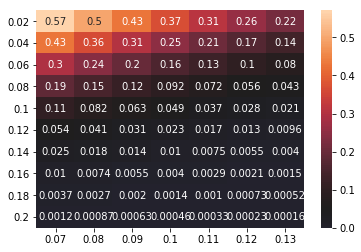

In [169]:
sns.heatmap(p_values.astype(float), annot=True)

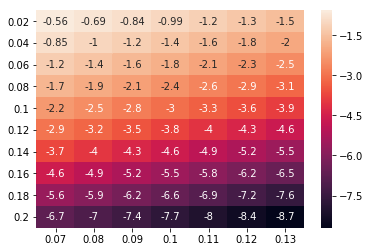

In [175]:
sns.heatmap(np.log(p_values.astype(float)), annot=True)